# Zillow Report

Lindy Castellaw
7/27/2022

A home is often the most expensive purchase a person makes. Ensuring homeowners have a trusted way to monitor this asset is important. For this project the goal will be testing out different features to see what can help predict home value better.

Workflow:

-Import Libraries 

-Exploratory Data Analysis

-Data cleaning 

-Data splitting

-Baseline model training

-Feature engineering

-Robust model Training and Hyperparameter tuning

-Conclusion & Future Work


In [1]:
# imports 
import numpy as np
import pandas as pd
import seaborn as sns
import wrangle
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from env import host, user, password
from wrangle import wrangle_zillow 
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LinearRegression, TweedieRegressor
from math import sqrt
from sklearn.preprocessing import RobustScaler

In [2]:
def get_db_url(database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

Acquire and Prep data
    
    - Handle outliers
    
    - Convert datatype
   
    - Rename columns

In [3]:
df = wrangle_zillow()
df.head()

,bedroom,bathroom,SqFt,home_value,year_built,tax_amount,pool
0,5.0,4.0,4872.0,970876.0,1991.0,12072.52,1.0
1,3.0,2.0,1812.0,241175.0,1974.0,3110.42,NaN
2,4.0,5.0,4066.0,1236000.0,1992.0,15095.14,1.0
3,4.0,4.0,3083.0,538410.0,1979.0,6700.97,1.0
4,4.0,3.0,2417.0,195224.0,1976.0,2557.31,1.0


In [4]:
# fill nulls in pool column with 0
df['pool'] = df['pool'].fillna(0)

In [5]:
# fill null values 
df.fillna(0)

,bedroom,bathroom,SqFt,home_value,year_built,tax_amount,pool
0,5.0,4.0,4872.0,970876.0,1991.0,12072.52,1.0
1,3.0,2.0,1812.0,241175.0,1974.0,3110.42,0.0
2,4.0,5.0,4066.0,1236000.0,1992.0,15095.14,1.0
3,4.0,4.0,3083.0,538410.0,1979.0,6700.97,1.0
4,4.0,3.0,2417.0,195224.0,1976.0,2557.31,1.0
...,...,...,...,...,...,...,...
56071,5.0,3.5,3870.0,1025191.0,2005.0,16301.18,0.0
56072,5.0,4.5,3680.0,1204081.0,2004.0,16019.90,0.0
56073,5.0,4.5,4039.0,1707049.0,2005.0,21168.34,0.0
56076,4.0,4.5,3117.0,1689116.0,2004.0,21864.84,0.0


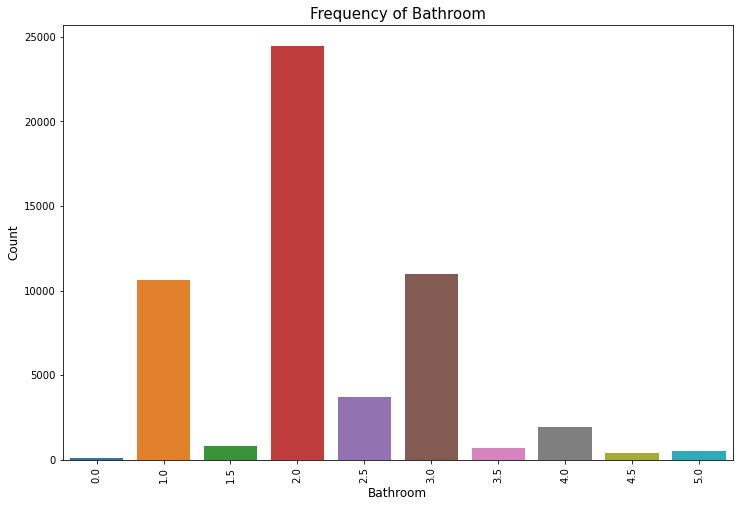

In [7]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroom", data=df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom", fontsize=15)
plt.show()

We will only be focusing on zero to five bathrooms since they are the most common.

Split Data into Train, Validate and Test

In [8]:
seed = 42

train, test_val = train_test_split(df, train_size=0.7,
                                   random_state=seed)

test, valid = train_test_split(test_val, train_size=0.5,
                               random_state=seed)

In [9]:
# make X and Y values 
X_train = train[['pool', 'SqFt', 'bedroom', 'bathroom']]
y_train = train.home_value
X_validate = valid[['pool', 'SqFt', 'bedroom', 'bathroom']]
y_validate = valid.home_value
X_test = test[['pool', 'SqFt', 'bedroom', 'bathroom']]
y_test = test.home_value

<AxesSubplot:>

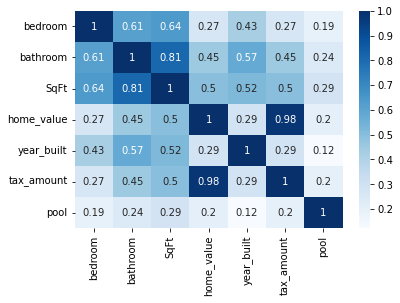

In [10]:
exam_corr = train.corr(method='spearman')
correlation_table = train.corr(method='spearman')
# sns.heatmap(correlation_table, cmap='Blues', annot=True, vmin=0, vmax=1)
sns.heatmap(correlation_table, cmap='Blues', annot=True)

The correlation of the target variable with the given set of variables are low overall, there is a higher correlation for bathroom 

Testing

I will be preforming a T test and Pearson R on bathroom and SqFt features on home value using train data.

Ha- Bathroom and SqFt affect home value

H0- They do not affect home value

In [11]:
alpha = 0.05

t, p = stats.ttest_ind(train.bathroom, train.home_value, equal_var=False)
t, p / 2


print(t, p/2, alpha)

if p/2 < alpha:
    print("We reject null")
else:
    print("We fail to reject null")

-252.29489125607014 0.0 0.05
We reject null


r = 0.56341
p = 0.0


Text(8, 80, 'r = 0.563')

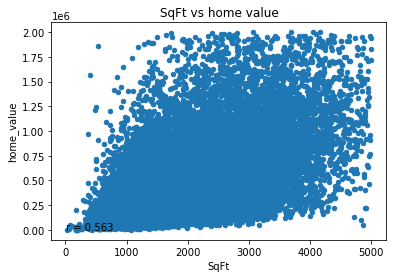

In [12]:
r, p = stats.pearsonr(train.SqFt, train.home_value)
print(f'r = {r:.5f}')
print(f'p = {p:.1f}')


df.plot.scatter('SqFt', 'home_value')
plt.title('SqFt vs home value')
plt.text(8, 80, f'r = {r:.3f}')

Both have low P values so we know that they are related from the tests. We will move onto feature engineering.

But first we must scale data with Robust Scaler

Text(0.5, 1.0, 'Scaled')

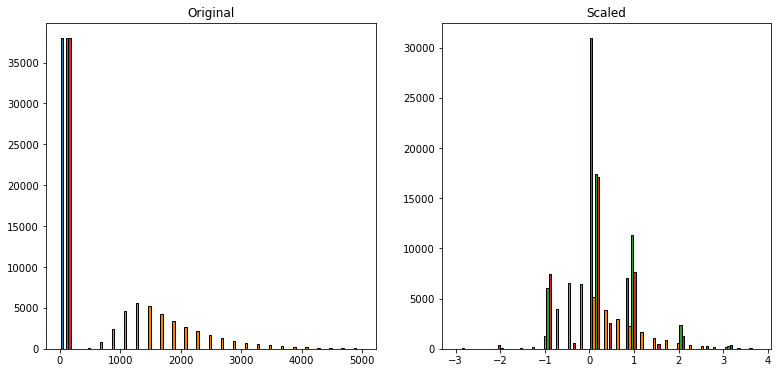

In [13]:
rs = sklearn.preprocessing.RobustScaler()
scaler = RobustScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index=X_validate.index, columns=X_validate.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# plot scaled data
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')

SelectKBest to pick the two top features for testing using scaled data.

In [14]:
kbest = SelectKBest(f_regression, k=2) #select 2 features
kbest.fit(X_train_scaled, y_train)
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train_scaled.columns)
kbest_results

,p,f
pool,0.0,1693.738504
SqFt,0.0,17660.948768
bedroom,0.0,2613.154760
bathroom,0.0,11482.995451


In [15]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train_scaled.columns)
kbest_results

,p,f
pool,0.0,1693.738504
SqFt,0.0,17660.948768
bedroom,0.0,2613.154760
bathroom,0.0,11482.995451


In [16]:
X_train_scaled.columns[kbest.get_support()]

X_train_transformed = pd.DataFrame(
    kbest.transform(X_train),
    index=X_train_scaled.index,
    columns=X_train_scaled.columns[kbest.get_support()]
)
X_train_transformed.head()

,SqFt,bathroom
14064,1120.0,1.0
29556,1869.0,3.0
23797,720.0,1.0
10575,1243.0,2.0
25618,1804.0,3.0


SqFt and Bathroom are the features we will model and will use X_train_transformed going forward.

## Modeling

LinearRegression

In [17]:
## fit model on x train transformed 
lm = LinearRegression().fit(X_train_transformed,
                            y_train)
lm_predict = lm.predict(X_train_transformed) #predictions
lm_predict

array([223144.5868305 , 432579.5614202 , 139701.09999215, ...,
       283741.33045957, 682593.02017233, 520195.22260047])

LassoLars

In [18]:
lars = LassoLars(alpha=0.05)
lars.fit(X_train_transformed, y_train)
lars_predict = lars.predict(X_train_transformed) #predictions

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


GLM

In [19]:
glm = TweedieRegressor(power=0, alpha=.05)

glm.fit(X_train_transformed, y_train)
glm_predict = glm.predict(X_train_transformed) #predictions

Prediction DF

I made a dataframe to hold all the models predictions and the baseline 

In [20]:
predictions = pd.DataFrame({
    'actual': train.home_value
})

In [21]:
predictions['lm'] = lm.predict(X_train_transformed)
predictions.head()

predictions['lars'] = lars.predict(X_train_transformed)
predictions.head()

predictions['glm'] = glm.predict(X_train_transformed)
predictions.head()

predictions['baseline'] = train.home_value.mean()

In [ ]:
predictions

## Evaluate RMSE

I am evaluating all the models on train

In [22]:
MSE = mean_squared_error(predictions.actual, predictions.lm)
import math #import math
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

248724.73766278697


In [23]:
MSE = mean_squared_error(predictions.actual, predictions.glm)
import math #import math
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

248734.8977894671


In [24]:
MSE = mean_squared_error(predictions.actual, predictions.lars)
import math #import math
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

248724.73787364666


Make a new predictions table with validate 

In [25]:
predictions_V = pd.DataFrame({
    'actual': valid.home_value
})

Transform X_validate using scaled data and make predictions 

In [26]:
# tranform x validate 
X_validate_transformed = pd.DataFrame(
    kbest.transform(X_validate_scaled),
    index=X_validate_scaled.index,
    columns=X_validate_scaled.columns[kbest.get_support()]
)
X_validate_transformed.head()

,SqFt,bathroom
2971,0.633509,1.0
34126,2.028341,1.5
11883,-0.467908,0.0
46033,1.658238,2.0
53562,0.296749,1.0


In [27]:
predictions_V['lm'] = lm.predict(X_validate_transformed)


predictions_V['lars'] = lars.predict(X_validate_transformed)


predictions_V['glm'] = glm.predict(X_validate_transformed)
predictions_V.head()


,actual,lm,lars,glm
2971,128060.0,-10365.020753,-10344.432444,-12603.061014
34126,556036.0,3222.714711,3240.069495,-1306.947508
11883,261570.0,-37188.308695,-37161.265817,-34835.894698
46033,512578.0,16442.269411,16456.403718,9613.447364
53562,258882.0,-10435.271868,-10414.681069,-12674.750400


In [28]:
MSE = mean_squared_error(predictions_V.actual, predictions_V.lars)

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

MSE = mean_squared_error(predictions_V.actual, predictions_V.lm)

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

MSE = mean_squared_error(predictions_V.actual, predictions_V.glm)

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

516751.6393016268
Root Mean Square Error:

516771.72730062704
Root Mean Square Error:

516389.63416049536


Make Test predictions

In [33]:
predictions_T = pd.DataFrame({
    'actual': test.home_value
})

In [35]:
predictions_T['lm'] = lm.predict(X_test_scaled)


predictions_T['lars'] = lars.predict(X_test_scaled)


predictions_T['glm'] = glm.predict(X_test_scaled)
predictions_T.head()


,actual,lm,lars,glm
6175,180727.0,-37141.706470,-37114.665244,-34788.338372
11832,53183.0,-37163.500545,-37136.458547,-34810.578644
36676,174407.0,-37037.604982,-37010.567446,-34682.105584
33439,508465.0,-23727.396202,-23703.582355,-23669.200646
28566,342234.0,-63735.692916,-63702.205249,-56787.176005


In [36]:
MSE = mean_squared_error(predictions_T.actual, predictions_T.glm)

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

521286.3752545341


# Summary 

My best Model was GLM with a RMSE of 521286.37. I think bringing in more features will help the accuracy of the models. Next time, I would try different scalers like MinMax, and Recursive Feature Elimination so see what results I get.

Next steps:

 -Try to improve prediction result by applying other Features selection.